In [1]:
import torch
torch.__version__

'2.7.0'

In [2]:
torch.cuda.is_available()

True

In [10]:
tensor0d = torch.tensor(1.0)
print(tensor0d.dtype)

torch.float32


In [7]:
tensor1d = torch.tensor([1,2,3])

In [9]:
tensor2d = torch.tensor([[1,2],[3,4]])
print(tensor2d.dtype)

torch.int64


In [13]:
print(tensor2d.shape)

torch.Size([2, 2])


In [7]:
import torch.nn.functional as F
from torch.autograd import grad

y = torch.tensor([1.0])
x1 = torch.tensor([1.1])
w1 = torch.tensor([1.1], requires_grad=True)
b = torch.tensor([0.0], requires_grad=True)

z = x1 * w1 + b
a = torch.sigmoid(z)

loss = F.binary_cross_entropy(a, y)

grad_L_w1 = grad(loss, w1, retain_graph=True)
grad_L_b = grad(loss, b, retain_graph=True)

print(loss)
print(grad_L_w1)
print(grad_L_b)

tensor(0.2610, grad_fn=<BinaryCrossEntropyBackward0>)
(tensor([-0.2527]),)
(tensor([-0.2297]),)


In [8]:
loss.backward()

In [12]:
print(w1.grad)
print(b.grad)

tensor([-0.2527])
tensor([-0.2297])


In [35]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),

            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),

            torch.nn.Linear(20, num_outputs)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

torch.manual_seed(123)
model = NeuralNetwork(50, 3)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

2213


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor([
    [-1.2, 3.1],
    [-0.9, 2.9],
    [-0.5, 2.6],
    [-2.3, -1.1],
    [2.7, -1.5]
]).to(device)
print(X_train)

y_train_tensor = torch.tensor([0,0,0,1,1]).to(device)
print(y_train)

X_test_tensor = torch.tensor([
    [-0.8, 2.8],
    [-2.6, -1.6]
])
X_test = X_test_tensor.to("cuda") if torch.cuda.is_available() else X_test_tensor

y_test_tensor = torch.tensor([0,1])
y_test = y_test_tensor.to("cuda") if torch.cuda.is_available() else y_test_tensor

tensor([[-1.2000,  3.1000],
        [-0.9000,  2.9000],
        [-0.5000,  2.6000],
        [-2.3000, -1.1000],
        [ 2.7000, -1.5000]], device='cuda:0')
tensor([0, 0, 0, 1, 1], device='cuda:0')


In [48]:
# dataset
from torch.utils.data import Dataset

class ToyDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        one_x = self.features[index]
        one_y = self.labels[index]
        return one_x, one_y

    def __len__(self):
        return self.labels.shape[0]

train_ds = ToyDataset(X_train, y_train)
test_ds = ToyDataset(X_test, y_test)
print(train_ds.__len__())
print(len(train_ds))
print(train_ds[0])
print(train_ds[0][0])
print(train_ds[0][0].shape)

5
5
(tensor([-1.2000,  3.1000], device='cuda:0'), tensor(0, device='cuda:0'))
tensor([-1.2000,  3.1000], device='cuda:0')
torch.Size([2])


In [49]:
# dataloader
from torch.utils.data import DataLoader

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0)

for idx, (x, y) in enumerate(train_loader):
    print(f"Batch {idx+1}:", x, y)

Batch 1: tensor([[-2.3000, -1.1000],
        [-0.9000,  2.9000]], device='cuda:0') tensor([1, 0], device='cuda:0')
Batch 2: tensor([[-1.2000,  3.1000],
        [-0.5000,  2.6000]], device='cuda:0') tensor([0, 0], device='cuda:0')


In [72]:
import torch.nn.functional as F
torch.manual_seed(123)
model = NeuralNetwork(num_inputs=2, num_outputs=2).to(device)
# lr = learning rate
# SGD: Stochastic Gradient Descent - θ=θ−lr×∇θ​L(θ)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
num_epochs = 10
loss_history = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        # optimizer和loss没有直接参数传递，它们的配合是：PyTorch 中的每个 tensor（只要 requires_grad=True）在计算过程中都会构建一个 计算图（computational graph）。
        # 执行 loss.backward() 时，PyTorch 会自动根据这个图，计算每个参数的梯度，并保存在对应的 .grad 属性中。
        # 所以：loss.backward() 会对 model.parameters() 中的每个参数 p 赋值：
        # p.grad = ∂loss/∂p
        # optimizer.step() 做的事情是：
        # for p in model.parameters():
        #    p = p - lr * p.grad
        # 🎯 所以，optimizer.step() 不用“主动”从 backward() 获取结果，而是直接从参数的 .grad 属性读取它们的梯度。
        
        # 1. 前向传播
        logits=model(features)
        
        # 2. 计算损失
        loss=F.cross_entropy(logits, labels)

        # 3. 清除旧梯度
        optimizer.zero_grad()

        # 4. 把所有模型参数的 .grad 填上梯度
        loss.backward()
        
        # 5. 遍历每个参数，根据 .grad 去更新参数值
        optimizer.step()

        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
            f" | Batch: {batch_idx+1:03d}/{len(train_loader):03d}"
            f" | Train Loss: {loss:.2f}")
   
    model.eval()
    
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for features, labels in train_loader:
            logits = model(features)
            loss = F.cross_entropy(logits, labels, reduction='sum')  # 先求每个样本的总损失
            total_loss += loss.item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1:03d} Completed | Avg Train Loss: {avg_loss:.4f}")

print("loss_history", loss_history)

# use trained model to predict
with torch.no_grad():
    X_digits = model(X_train)
print(X_digits)

torch.set_printoptions(sci_mode=False)
probas = torch.softmax(X_digits, dim=1)
print(probas)

predictions = torch.argmax(X_digits, dim=1)
print(predictions)

predictions == y_train
torch.sum(predictions == y_train)

Epoch: 001/010 | Batch: 001/002 | Train Loss: 0.75
Epoch: 001/010 | Batch: 002/002 | Train Loss: 0.85
Epoch 001 Completed | Avg Train Loss: 0.3764
Epoch: 002/010 | Batch: 001/002 | Train Loss: 0.48
Epoch: 002/010 | Batch: 002/002 | Train Loss: 0.07
Epoch 002 Completed | Avg Train Loss: 0.0773
Epoch: 003/010 | Batch: 001/002 | Train Loss: 0.01
Epoch: 003/010 | Batch: 002/002 | Train Loss: 0.15
Epoch 003 Completed | Avg Train Loss: 0.0209
Epoch: 004/010 | Batch: 001/002 | Train Loss: 0.01
Epoch: 004/010 | Batch: 002/002 | Train Loss: 0.03
Epoch 004 Completed | Avg Train Loss: 0.0102
Epoch: 005/010 | Batch: 001/002 | Train Loss: 0.01
Epoch: 005/010 | Batch: 002/002 | Train Loss: 0.01
Epoch 005 Completed | Avg Train Loss: 0.0096
Epoch: 006/010 | Batch: 001/002 | Train Loss: 0.01
Epoch: 006/010 | Batch: 002/002 | Train Loss: 0.01
Epoch 006 Completed | Avg Train Loss: 0.0055
Epoch: 007/010 | Batch: 001/002 | Train Loss: 0.01
Epoch: 007/010 | Batch: 002/002 | Train Loss: 0.00
Epoch 007 Comple

tensor(5, device='cuda:0')


✅ Training complete.


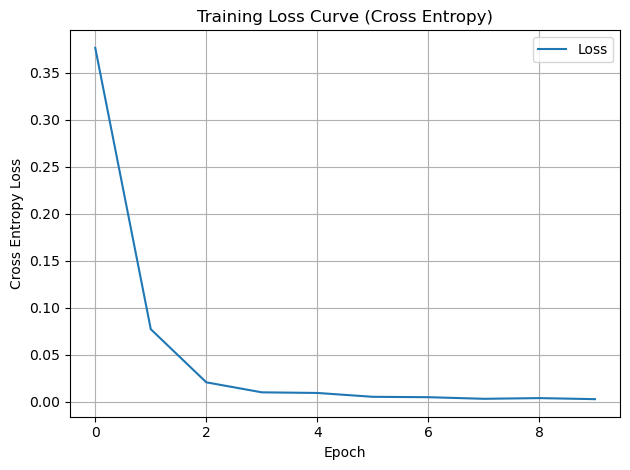

In [73]:
# output
print("\n✅ Training complete.")

# visulize losses
import matplotlib.pyplot as plt
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title(f"Training Loss Curve (Cross Entropy)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()